In [3]:
import pandas as pd
import torch
from torch import nn
from torch.utils.data import DataLoader
from transformers import BertModel, BertTokenizer
from torch.optim import AdamW

from sklearn.metrics import accuracy_score
import torch.nn.functional as F

train_df = pd.read_csv("/content/drive/MyDrive/nlp3/train.csv")
val_df = pd.read_csv("/content/drive/MyDrive/nlp3/val.csv")
test_df = pd.read_csv("/content/drive/MyDrive/nlp3/test.csv")

def map_label(score):
    if score in [0, 1]:
        return 0
    elif score == 2:
        return 1
    else:
        return 2

train_df['label'] = train_df['label'].apply(map_label)
val_df['label'] = val_df['label'].apply(map_label)
test_df['label'] = test_df['label'].apply(map_label)

class SoftPromptBERT(nn.Module):
    def __init__(self, model_name="bert-base-uncased", prompt_length=10, num_labels=3):
        super().__init__()
        self.bert = BertModel.from_pretrained(model_name)
        for param in self.bert.parameters():
            param.requires_grad = False

        self.tokenizer = BertTokenizer.from_pretrained(model_name)
        self.prompt_length = prompt_length
        self.embedding_dim = self.bert.config.hidden_size

        self.soft_prompt = nn.Parameter(torch.randn(prompt_length, self.embedding_dim))
        self.classifier = nn.Linear(self.embedding_dim, num_labels)

    def forward(self, input_ids, attention_mask):
        inputs_embeds = self.bert.embeddings(input_ids)
        soft_prompt = self.soft_prompt.unsqueeze(0).expand(input_ids.size(0), -1, -1)
        inputs_embeds = torch.cat([soft_prompt, inputs_embeds], dim=1)

        prompt_mask = torch.ones((input_ids.size(0), self.prompt_length), dtype=torch.long).to(input_ids.device)
        attention_mask = torch.cat([prompt_mask, attention_mask], dim=1)

        outputs = self.bert(inputs_embeds=inputs_embeds, attention_mask=attention_mask)
        cls_output = outputs.last_hidden_state[:, self.prompt_length, :]
        return self.classifier(cls_output)

class YelpDataset(torch.utils.data.Dataset):
    def __init__(self, df, tokenizer):
        self.texts = df['text'].tolist()
        self.labels = df['label'].tolist()
        self.tokenizer = tokenizer

    def __getitem__(self, idx):
        encoding = self.tokenizer(self.texts[idx], truncation=True, padding='max_length', max_length=128, return_tensors='pt')
        return {
            'input_ids': encoding['input_ids'].squeeze(),
            'attention_mask': encoding['attention_mask'].squeeze(),
            'label': torch.tensor(self.labels[idx], dtype=torch.long)
        }

    def __len__(self):
        return len(self.labels)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")
model = SoftPromptBERT().to(device)
optimizer = AdamW(model.parameters(), lr=5e-4)
loss_fn = nn.CrossEntropyLoss()

train_dataset = YelpDataset(train_df, tokenizer)
val_dataset = YelpDataset(val_df, tokenizer)

train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32)

for epoch in range(20):
    model.train()
    total_loss = 0
    for batch in train_loader:
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['label'].to(device)

        optimizer.zero_grad()
        outputs = model(input_ids, attention_mask)
        loss = loss_fn(outputs, labels)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()

    model.eval()
    val_preds = []
    val_labels = []
    with torch.no_grad():
        for batch in val_loader:
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['label'].to(device)

            outputs = model(input_ids, attention_mask)
            preds = torch.argmax(outputs, dim=1)

            val_preds.extend(preds.cpu().numpy())
            val_labels.extend(labels.cpu().numpy())

    val_accuracy = accuracy_score(val_labels, val_preds)

    print(f"Epoch {epoch+1}: Train loss = {total_loss/len(train_loader):.4f}, Val Accuracy = {val_accuracy:.4f}")


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Epoch 1: Train loss = 0.8861, Val Accuracy = 0.6835
Epoch 2: Train loss = 0.7667, Val Accuracy = 0.7040
Epoch 3: Train loss = 0.7261, Val Accuracy = 0.7090
Epoch 4: Train loss = 0.7078, Val Accuracy = 0.7170
Epoch 5: Train loss = 0.6974, Val Accuracy = 0.7205
Epoch 6: Train loss = 0.6957, Val Accuracy = 0.7210
Epoch 7: Train loss = 0.6897, Val Accuracy = 0.7220
Epoch 8: Train loss = 0.6817, Val Accuracy = 0.7250
Epoch 9: Train loss = 0.6780, Val Accuracy = 0.7285
Epoch 10: Train loss = 0.6746, Val Accuracy = 0.7365
Epoch 11: Train loss = 0.6742, Val Accuracy = 0.7305
Epoch 12: Train loss = 0.6681, Val Accuracy = 0.7275
Epoch 13: Train loss = 0.6648, Val Accuracy = 0.7210
Epoch 14: Train loss = 0.6563, Val Accuracy = 0.7300
Epoch 15: Train loss = 0.6606, Val Accuracy = 0.7340
Epoch 16: Train loss = 0.6583, Val Accuracy = 0.7295
Epoch 17: Train loss = 0.6566, Val Accuracy = 0.7360
Epoch 18: Train loss = 0.6533, Val Accuracy = 0.7300
Epoch 19: Train loss = 0.6536, Val Accuracy = 0.7345
Ep

Accuracy: 0.7185

Class 0 Metrics:
Precision: 0.7421
Recall: 0.8818
F1-score: 0.8060

Class 1 Metrics:
Precision: 0.6415
Recall: 0.0846
F1-score: 0.1495

Class 2 Metrics:
Precision: 0.6985
Recall: 0.8739
F1-score: 0.7764

Weighted Precision: 0.7051
Weighted Recall: 0.7185
Weighted F1: 0.6626


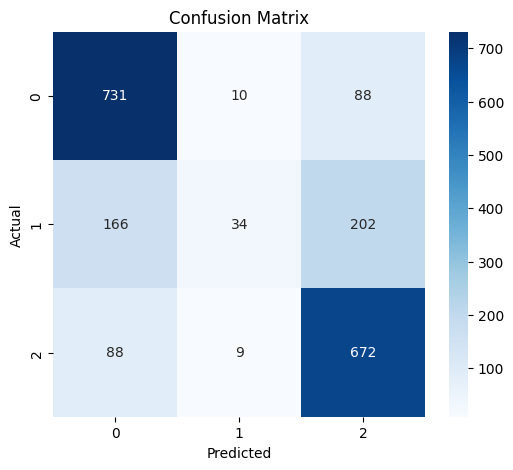

In [4]:
from collections import Counter
import numpy as np

test_dataset = YelpDataset(test_df, tokenizer)
test_loader = DataLoader(test_dataset, batch_size=32)

model.eval()
test_preds = []
test_labels = []

with torch.no_grad():
    for batch in test_loader:
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['label'].to(device)

        outputs = model(input_ids, attention_mask)
        preds = torch.argmax(outputs, dim=1)

        test_preds.extend(preds.cpu().numpy())
        test_labels.extend(labels.cpu().numpy())

num_classes = 3
conf_matrix = np.zeros((num_classes, num_classes), dtype=int)

for true_label, pred_label in zip(test_labels, test_preds):
    conf_matrix[true_label][pred_label] += 1

class_metrics = []
total_samples = len(test_labels)
class_counts = Counter(test_labels)

correct = sum([conf_matrix[i][i] for i in range(num_classes)])
accuracy = correct / total_samples

weighted_precision = 0
weighted_recall = 0
weighted_f1 = 0

print(f"Accuracy: {accuracy:.4f}")

for cls in range(num_classes):
    TP = conf_matrix[cls][cls]
    FP = sum(conf_matrix[:, cls]) - TP
    FN = sum(conf_matrix[cls, :]) - TP

    precision = TP / (TP + FP) if TP + FP > 0 else 0.0
    recall = TP / (TP + FN) if TP + FN > 0 else 0.0
    f1 = 2 * precision * recall / (precision + recall) if precision + recall > 0 else 0.0

    weight = class_counts[cls] / total_samples
    weighted_precision += precision * weight
    weighted_recall += recall * weight
    weighted_f1 += f1 * weight

    print(f"\nClass {cls} Metrics:")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1-score: {f1:.4f}")

print(f"\nWeighted Precision: {weighted_precision:.4f}")
print(f"Weighted Recall: {weighted_recall:.4f}")
print(f"Weighted F1: {weighted_f1:.4f}")



import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(6, 5))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=[0, 1, 2], yticklabels=[0, 1, 2])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()
